In [1]:
from chromadb.utils import embedding_functions

class CustomEmbeddingFunction(embedding_functions.EmbeddingFunction):
    def __init__(self, embedding_model):
        self.embedding_model = embedding_model
    
    def __call__(self, texts):
        return self.embedding_model.encode(texts).tolist()

In [2]:
import os
import pathlib
import chromadb
import shutil
import time

class ChromaVectorDB:
    def __init__(self, embedding_model, persist_directory="./chroma_db", collection_name="Gray"):
        os.makedirs(persist_directory, exist_ok=True)
        
        self.embedding_model = embedding_model
        
        db_path = pathlib.Path(persist_directory)
        db_exists = db_path.exists() and any(db_path.iterdir())
        
        self.embedding_function = CustomEmbeddingFunction(self.embedding_model)
        
        try:
            self.client = chromadb.PersistentClient(path=persist_directory)
            
            try:
                self.collection = self.client.get_collection(
                    name=collection_name,
                    embedding_function=self.embedding_function
                )
                print(f"기존 컬렉션 '{collection_name}'을 로드했습니다.")
            except Exception as e:
                print(f"컬렉션 로드 중 오류 발생: {e}")
                
                if "max_seq_id" in str(e) or "PersistentData" in str(e):
                    try:
                        self.client.delete_collection(name=collection_name)
                        print(f"기존 컬렉션 '{collection_name}'을 삭제했습니다.")
                    except:
                        pass
                    
                    self.collection = self.client.create_collection(
                        name=collection_name,
                        embedding_function=self.embedding_function
                    )
                else:
                    self.collection = self.client.create_collection(
                        name=collection_name,
                        embedding_function=self.embedding_function
                    )
                    
        except Exception:
            if db_exists:
                backup_dir = f"{persist_directory}_backup_{int(time.time())}"
                try:
                    shutil.move(persist_directory, backup_dir)
                    print(f"기존 데이터베이스를 {backup_dir}로 백업했습니다.")
                except Exception as move_err:
                    print(f"백업 실패: {move_err}")
                    try:
                        shutil.rmtree(persist_directory)
                    except Exception as rm_err:
                        print(f"폴더 삭제 실패: {rm_err}")
            
            os.makedirs(persist_directory, exist_ok=True)
            
            self.client = chromadb.PersistentClient(path=persist_directory)
            self.collection = self.client.create_collection(
                name=collection_name,
                embedding_function=self.embedding_function
            )

    def get_all_documents(self):
        """
        현재 컬렉션의 모든 문서와 임베딩을 반환
        """
        try:
            if hasattr(self.collection, 'get'):
                results = self.collection.get(
                    include=['documents', 'embeddings', 'metadatas']
                )
                
                documents = []
                for i, (doc, embedding, metadata) in enumerate(zip(
                    results.get('documents', []),
                    results.get('embeddings', []),
                    results.get('metadatas', [])
                )):
                    documents.append({
                        'index': i,
                        'chunk': doc,
                        'document': doc,
                        'text': doc,
                        'embedding': embedding,
                        'page': metadata.get('page', 1) if metadata else 1,
                        'metadata': metadata or {}
                    })
                
                return documents
                
            elif hasattr(self, 'documents') and hasattr(self, 'embeddings'):
                documents = []
                for i, (doc, embedding) in enumerate(zip(self.documents, self.embeddings)):
                    documents.append({
                        'index': i,
                        'chunk': doc,
                        'document': doc,
                        'text': doc,
                        'embedding': embedding,
                        'page': getattr(doc, 'page', 1) if hasattr(doc, 'page') else 1,
                        'metadata': getattr(doc, 'metadata', {}) if hasattr(doc, 'metadata') else {}
                    })
                
                return documents
                
            else:
                raise NotImplementedError("get_all_documents 메서드를 벡터DB 클래스에 맞게 구현해야 합니다.")
                
        except Exception as e:
            print(f"문서 가져오기 중 오류: {e}")
            return []
    
    def change_collection(self, collection_name):
        """컬렉션 변경"""
        try:
            self.collection = self.client.get_collection(name=collection_name)
            self.collection_name = collection_name
            return True
        except Exception as e:
            print(f"컬렉션 변경 실패: {e}")
            return False
        
    def search_with_embedding(self, embedding, top_n=5):
        try :
            results = self.collection.query(
                query_embeddings=[embedding],
                n_results=top_n,
                include=["documents", "metadatas", "distances"]
            )
            
            formatted_results = []
            if results['documents'] and results['documents'][0]:
                for i, (doc, metadata, distance) in enumerate(zip(
                    results['documents'][0], 
                    results['metadatas'][0], 
                    results['distances'][0]
                )):
                    formatted_results.append({
                        'id': results['ids'][0][i] if 'ids' in results else f"doc_{i}",
                        'document': doc,
                        'chunk': doc,
                        'distance': distance,
                        'page': metadata.get('page', 1) if metadata else 1,
                        'index': i
                    })
            
            return formatted_results
        except Exception as e:
            print(f"임베딩 검색 실패: {e}")
            return []

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import numpy as np
import re

class HybridSearcher:
    def __init__(self, embedding_model, chunk_size=200, chunk_overlap=50, 
                 persist_directory="./chroma_db", collection_name="Gray"):

        self.embedding_model = embedding_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.collection_name = collection_name
        self.chunks = None
        self.chunk_metadata = None
        self.bm25_index = None
        self.vector_index = None
        self.persist_directory=persist_directory
        
        self.vector_db = ChromaVectorDB(
            embedding_model=self.embedding_model,
            persist_directory=persist_directory,
            collection_name=collection_name
        )
        
        self.debug_mode = False
        
        self.complexity_prompt = self._load_prompt("prompts/en/complex/complex_prompt.txt")
        self.decompose_prompt = self._load_prompt("prompts/en/decompose/decompose_prompt.txt")

    def _load_prompt(self, file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    
    def change_collection(self, collection_name):
        """컬렉션 변경"""
        try:
            self.collection = self.client.get_collection(name=collection_name)
            self.collection_name = collection_name
            return True
        except Exception as e:
            print(f"컬렉션 변경 실패: {e}")
            return False

    def create_bm25_for_all_collections(self):
        """모든 컬렉션에 대해 BM25 인덱스 생성"""
        collections = ["1_Embryology", "2_Osteology", "3_Syndesmology", "4_Myology",
                    "5_Angiology", "6_The_Arteries", "7_The_Veins", "8_The_Lymphatic_System",
                    "9_Neurology", "10_The_Organs_of_the_Senses_and_the_Common_Integument",
                    "11_Splanchnology", "12_Surface_Anatomy_and_Surface_Markings"]
        
        self.bm25_indices = {}  
        original_collection = getattr(self.vector_db, 'collection_name', None)
        
        for collection_name in collections:
            try:
                print(f"컬렉션 {collection_name}에 BM25 인덱스 생성 중...")
                self.vector_db.change_collection(collection_name)
                
                all_documents = self.vector_db.get_all_documents()
                if not all_documents:
                    print(f"컬렉션 {collection_name}에 문서가 없습니다.")
                    continue
                
                texts = []
                for doc in all_documents:
                    text = doc.get('chunk', doc.get('document', doc.get('text', '')))
                    if text:
                        tokens = text.lower().split()
                        texts.append(tokens)
                
                if texts:
                    bm25_index = BM25Okapi(texts)
                    self.bm25_indices[collection_name] = bm25_index
                    print(f"컬렉션 {collection_name} BM25 인덱스 생성 완료 ({len(texts)}개 문서)")
                else:
                    print(f"컬렉션 {collection_name}에 유효한 텍스트가 없습니다.")
                    
            except Exception as e:
                print(f"컬렉션 {collection_name} BM25 인덱스 생성 실패: {e}")
                continue
        
        if original_collection:
            try:
                self.vector_db.change_collection(original_collection)
            except:
                pass
        
        print(f"총 {len(self.bm25_indices)}개 컬렉션에 BM25 인덱스 생성 완료")

    def get_bm25_index(self, collection_name):
        if not hasattr(self, 'bm25_indices'):
            self.bm25_indices = {}
        
        return self.bm25_indices.get(collection_name, None)

    def multi_collection_search(self, query, top_n_per_collection=5, final_top_n=5, alpha=0.5):
        collections = ["1_Embryology", "2_Osteology", "3_Syndesmology", "4_Myology",
                    "5_Angiology", "6_The_Arteries", "7_The_Veins", "8_The_Lymphatic_System",
                    "9_Neurology", "10_The_Organs_of_the_Senses_and_the_Common_Integument",
                    "11_Splanchnology", "12_Surface_Anatomy_and_Surface_Markings"]
        
        if not hasattr(self, 'bm25_indices') or not self.bm25_indices:
            self.create_bm25_for_all_collections()
        
        all_results = []
        original_collection = getattr(self.vector_db, 'collection_name', None)
        
        if not isinstance(query, str):
            query = str(query)
        
        query_parts = re.split(r'[.!?;]', query)
        query_parts = [part.strip() for part in query_parts if part.strip()]
        
        if query_parts:
            part_embeddings = self.embedding_model.encode(query_parts)
            query_embedding = np.mean(part_embeddings, axis=0)
        else:
            query_embedding = self.embedding_model.encode([query])[0]
        
        query_tokens = query.lower().split()
        
        for collection_name in collections:
            try:
                self.vector_db.change_collection(collection_name)
                
                all_documents = self.vector_db.get_all_documents()
                if not all_documents:
                    continue
                    
                doc_embeddings = np.array([doc['embedding'] for doc in all_documents])
                
                bm25_index = self.get_bm25_index(collection_name)
                
                if bm25_index is None:
                    cosine_scores = cosine_similarity([query_embedding], doc_embeddings)[0]
                    
                    max_cosine = max(cosine_scores) if max(cosine_scores) > 0 else 1.0
                    norm_cosine_scores = cosine_scores / max_cosine
                    
                    hybrid_scores = []
                    for i, doc in enumerate(all_documents):
                        combined_score = norm_cosine_scores[i]
                        hybrid_scores.append({
                            'index': i,
                            'doc': doc,
                            'combined_score': combined_score,
                            'vector_score': norm_cosine_scores[i],
                            'bm25_score': 0.0
                        })
                else:
                    bm25_scores = bm25_index.get_scores(query_tokens)
                    cosine_scores = cosine_similarity([query_embedding], doc_embeddings)[0]
                    
                    max_bm25 = max(bm25_scores) if len(bm25_scores) > 0 and max(bm25_scores) > 0 else 1.0
                    max_cosine = max(cosine_scores) if max(cosine_scores) > 0 else 1.0
                    
                    norm_bm25_scores = bm25_scores / max_bm25
                    norm_cosine_scores = cosine_scores / max_cosine
                    
                    hybrid_scores = []
                    for i, doc in enumerate(all_documents):
                        bm25_score = norm_bm25_scores[i] if i < len(norm_bm25_scores) else 0.0
                        cosine_score = norm_cosine_scores[i]
                        combined_score = alpha * cosine_score + (1 - alpha) * bm25_score
                        
                        hybrid_scores.append({
                            'index': i,
                            'doc': doc,
                            'combined_score': combined_score,
                            'vector_score': cosine_score,
                            'bm25_score': bm25_score
                        })
                
                hybrid_scores.sort(key=lambda x: x['combined_score'], reverse=True)
                top_results = hybrid_scores[:top_n_per_collection]
                
                for result in top_results:
                    doc = result['doc']
                    all_results.append({
                        'chunk': doc.get('chunk', doc.get('document', doc.get('text', ''))),
                        'collection': collection_name,
                        'combined_score': result['combined_score'],
                        'vector_score': result['vector_score'],
                        'bm25_score': result['bm25_score'], 
                        'index': result['index'],
                        'page': doc.get('page', 1)
                    })
                    
            except Exception as e:
                print(f"컬렉션 {collection_name} 검색 중 오류: {e}")
                continue
        
        if original_collection:
            try:
                self.vector_db.change_collection(original_collection)
            except:
                pass
        
        all_results.sort(key=lambda x: x['combined_score'], reverse=True)
        final_results = all_results[:final_top_n]
        
        formatted_results = []
        for result in final_results:
            formatted_results.append({
                "chunk": result['chunk'],
                "score": result['combined_score'],
                "bm25_score": result['bm25_score'],
                "vector_score": result['vector_score'],
                "memory_score": result['combined_score'],
                "index": result['index'],
                "page": result['page'],
                "collection": result['collection']
            })
        
        return formatted_results

In [11]:
from model_loader.config import *
from save_utils import *
from translate import *
from PIL import Image
import matplotlib.pyplot as plt
import time

class Generation:
    def __init__(self, generation_loader, data_folder="./data/split_file", 
                 prompt_path_ko="./prompts/ko/generation/gemma3/generation_prompt2.txt", 
                 prompt_path_en="./prompts/en/generation/gemma3/generation_prompt2.txt", 
                 result_path="./result/5월12일/gemma3",
                 use_vector_db=True, 
                 persist_directory="./chroma_db",
                 collection_name="Gray",
                 language="en"):
        """
        자동차 매뉴얼 Q&A 시스템 초기화
        
        Args:
            generation_loader: 텍스트 생성 모델 로더
            data_folder (str): 분할된 데이터 파일들이 있는 폴더 경로
            prompt_path (str): 프롬프트 템플릿 파일 경로
            result_path (str): 결과를 저장할 경로
            use_vector_db (bool): ChromaDB 벡터 DB 사용 여부
            persist_directory (str): 벡터 DB 저장 경로
            collection_name (str): 벡터 DB 컬렉션 이름
        """
        self.data_folder = data_folder
        self.result_path = result_path
        self.use_vector_db = use_vector_db
        self.language = language
        self.persist_directory = persist_directory
        self.image_dir = "./data/images/anatomy"
        collection_name = f"{collection_name}"
        
        self.searcher = HybridSearcher(
            embedding_model=embedding_loader,
            chunk_size=200, 
            chunk_overlap=50,
            persist_directory=persist_directory,
            collection_name=collection_name
        )
        
        self.loader = generation_loader
        self.prompt_path_ko = prompt_path_ko
        self.prompt_path_en = prompt_path_en

        if language=="ko" :
            self.prompt_template = self._load_prompt(prompt_path_ko)
        else :
            self.prompt_template = self._load_prompt(prompt_path_en)
        
        try :
            self.translate_en_to_ko = en_to_ko
        except ImportError :
            print("translate.py 모듈을 임포트할 수 없습니다.")
            self.translate_en_to_ko = en_to_ko

        self.loaded_files = set()
        
        self.preload_all = False
        
        self.debug_mode = True

    def _load_prompt(self, path):
        """프롬프트 템플릿 로드"""
        try:
            with open(path, "r", encoding="utf-8") as f:
                return f.read()
        except Exception as e:
            print(f"[ERROR] 프롬프트 로드 실패: {e}")
            raise

    def _generate_hypothetical_document(self, query):
        """
        질문에 대한 가상 문서 생성 (Hyde 기법)
        
        Args:
            query (str): 사용자 질의
            
        Returns:
            str: 생성된 가상 문서
        """
        hyde_prompt = """Write a concise and accurate hypothetical document content for the following question:
            Question: {query}
            Guidelines:
            1. Include only essential information in 100 words.
            2. Be sure to include important keywords and technical terminology related to the question.
            3. Limit to 2-3 paragraphs, with each paragraph addressing a clear topic.
            4. Focus on facts and omit unnecessary explanations or examples.
            5. Write in an objective style as would appear in a professional reference or textbook.
            6. This document should be optimized for vector search. Therefore, include abundant relevant terminology and synonyms while keeping the overall length short.
            7. Do not use any markdown syntax in your response.
        """
            
        prompt = hyde_prompt.format(query=query)
        
        if hasattr(self.loader, "tokenizer"):
            tokenizer = self.loader.tokenizer
            model = self.loader.model
            
            input_ids = tokenizer.encode(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(model.device)
            
            output = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=400,
                temperature=0.7,  
                do_sample=True,
                top_p=0.85,
                repetition_penalty=1.2,
                early_stopping=True,
                num_beams=1,  
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
            generated_ids = output[0][input_ids.shape[-1]:]
            hypothetical_doc = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
        else:
            hypothetical_doc = self.loader.generate(prompt)
        
        return hypothetical_doc
    
    def _display_images_from_text(self, text) :
        page_patterns = [
            r"(\d+)\s*페이지",
            r"page\s*(\d+)",
            r"페이지\s*(\d+)",
            r"(\d+)\s*page"
        ]

        page_numbers = []
        for pattern in page_patterns :
            matches = re.findall(pattern, text, re.IGNORECASE)
            page_numbers.extend(matches)

        for page_number in page_numbers :
            images = self._get_images_for_page(page_number)
            if images :
                print(f"{page_number}페이지 관련 이미지 :")
                self._display_images(images)
            else :
                print(f"{page_number}페이지 : 관련 이미지 없음")

    def _get_images_for_page(self, page_number) :
        try :
            files = os.listdir(self.image_dir)
            return [f for f in files if f.startswith(f"image_{page_number}_") and f.endswith(".png")]
        except FileNotFoundError :
            print(f"폴더를 찾을 수 없습니다 : {self.image_dir}")
            return []
        
    def _display_images(self, image_files) :
        for img_file in image_files :
            img_path = os.path.join(self.image_dir, img_file)
            try :
                img = Image.open(img_path)
                plt.figure(figsize=(5,4))
                plt.imshow(img)
                plt.title(img_file)
                plt.axis("off")
                plt.show()
            except Exception as e :
                print(f"이미지를 열 수 없음 : {img_file} - {e}")
            
    def generate_response(self, query, alpha=0.5, target_language=None, idx=1):
        try:
            response_language = target_language if target_language else self.language
            source_language = self.language

            hyde_start = time.time()
            hypothetical_doc = self._generate_hypothetical_document(query)
            if self.debug_mode:
                print(f"가상 문서 : {hypothetical_doc}")
            hyde_end = time.time()
            
            if self.debug_mode:
                print(f"가상 문서 생성 시간 : {hyde_end - hyde_start}")
            search_start = time.time()
            
            search_results = self.searcher.multi_collection_search( 
                query=hypothetical_doc, 
                top_n_per_collection=5, 
                alpha=alpha,
                final_top_n=10
                )   
            
            search_end = time.time()
            if self.debug_mode :
                print("검색 시간 : ", search_end - search_start)

            context = "\n\n".join([f"#### Page {result['page']}\n{result['chunk']}" for result in search_results])

            prompt = self.prompt_template.format(context=context, query=query)

            generation_start = time.time()
            if hasattr(self.loader, "tokenizer"):
                tokenizer = self.loader.tokenizer
                model = self.loader.model
                
                input_ids = tokenizer.encode(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
                attention_mask = (input_ids != tokenizer.pad_token_id).long().to(model.device)
                
                output = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=400,
                    temperature=0.3,
                    do_sample=False,
                    top_p=0.85,
                    repetition_penalty=1.2,
                    early_stopping=True,
                    num_beams=3,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                )
                generated_ids = output[0][input_ids.shape[-1]:]
                raw_answer = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
            else:
                raw_answer = self.loader.generate(prompt)
            generation_end = time.time()
            if self.debug_mode :
                print("응답 생성 시간 : ", generation_end - generation_start)

            translated_answer = None
            if source_language == "en" and response_language == "ko" :
                if self.translate_en_to_ko :
                    try :
                        translate_start = time.time()
                        translated_answer = self.translate_en_to_ko(raw_answer)
                        translate_end = time.time()
                        if self.debug_mode :
                            print("영어 -> 한국어 번역 완료, 번역 시간 : ", translate_end - translate_start)
                    except Exception as e :
                        print(f"번역 중 오류 발생 : {e}")
                        translated_answer = f"[번역 오류] {raw_answer}"
                else :
                    translated_answer = f"[번역 모듈 없음] {raw_answer}"
            
            self._display_images_from_text(raw_answer)
            
            response = {
                "답변": raw_answer,
                "문서 일부": context,
                "question_en": query,
                "answer_en": raw_answer,
            }
            
            if translated_answer :
                response["번역된 답변"] = translated_answer
                
            
            try:
                result_path = getattr(self, 'result_path', '../result')
                os.makedirs(result_path, exist_ok=True)

                if self.debug_mode:
                    print(f"저장 시도: {result_path}")
                save_response_to_file(
                    query=query,
                    answer=response["답변"],
                    context=response["문서 일부"],
                    folder=result_path,
                    idx=idx
                )
                if self.debug_mode:
                    print(f"저장 완료: {result_path}")
            except Exception as e:
                print(f"결과 저장 중 오류 발생: {e}")
            
            return response
            
        except Exception as e:
            error_msg = f"[생성 오류] {str(e)}"
            print(error_msg)
            import traceback
            traceback.print_exc()
            return {"답변": error_msg, "후처리": error_msg}

기존 컬렉션 'Gray'을 로드했습니다.

======================Alpha 값 : 0.7======================
가상 문서 : ## Polyspermy & Early Embryonic Development – Effects on Fertilization

Polyspermy, the fertilization of an ovum by multiple spermatozoa, invariably leads to aneuploidy and developmental arrest. This occurs because multiple sperm contribute redundant and incompatible genetic material—multiple pronuclei—disrupting normal zygotic genome activation. Resultant embryos exhibit polyploidy, typically triploidy or tetraploidy, incompatible with viable development. 

The primary consequence is abnormal cleavage and failed blastocyst formation. Mechanisms preventing polyspermy—zona reaction and cortical reaction—are crucial; failure results in a non-viable conceptus. Though rare in humans, polyspermy is a significant cause of early pregnancy loss and embryonic lethality, characterized by chromosomal abnormalities and a lack of normal embryogenesis. These failures stem from disrupted mitotic spindle formatio

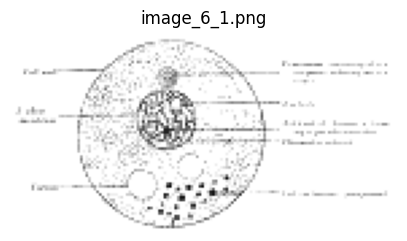

저장 시도: ./result/6월5일/en-gemma3/HyDE_mean_split/alpha_0.8
저장 완료: ./result/6월5일/en-gemma3/HyDE_mean_split/alpha_0.8
LLM 답변: According to page 6, “when this occurs the ovum usually develops in an abnormal manner and gives rise to a monstrosity.”

======================Alpha 값 : 0.9======================
가상 문서 : ## Polyspermy & Early Embryonic Development – Effects

Polyspermy, the fertilization of an ovum by multiple spermatozoa, invariably leads to aneuploidy – an abnormal number of chromosomes. This results from the duplication of paternal genetic material, disrupting the typical diploid chromosomal complement (2n). Specifically, multiple sperm contribute centrioles, causing multipolar spindle formation during the first mitotic division. 

The consequence is a non-viable zygote. Polyploidy, often triploidy (3n), is the typical outcome. These embryos exhibit severe developmental defects, halting gestation. Mechanisms preventing polyspermy—like the fast block (membrane depolarization) and

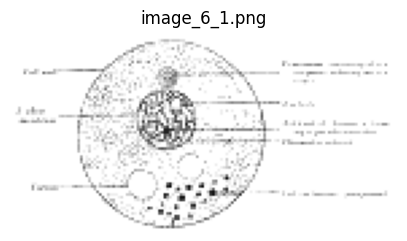

저장 시도: ./result/6월5일/en-gemma3/HyDE_mean_split/alpha_1.0
저장 완료: ./result/6월5일/en-gemma3/HyDE_mean_split/alpha_1.0
LLM 답변: According to page 6, "when this occurs the ovum usually develops in an abnormal manner and gives rise to a monstrosity."


In [ ]:
from model_loader.config import *
import os

questions = [
    "How many bones make up the adult human skeleton?",
    "What are the four main classes of bones?",
    "Where does segmentation of the fertilized ovum occur?",
    "What is the role of the notochord?",
    "What are the two types of bone marrow and what are their differences?",
    "What is the difference between intramembranous ossification and intracartilaginous ossification in bone formation?",
    "What are the structural components that make up a typical vertebra?",
    "What constitutes the fetal and maternal portions of the placenta?",
    "What major changes are observed in the embryo during the fourth week of development?",
    "How are the neural folds and neural tube formed during human embryonic development?",
    "Where does the abdominal aorta begin and end?",
    "How many valves are in the femoral vein?",
    "What are the main tributaries of the portal vein?",
    "Where do the pulmonary veins begin and where do they end?",
    "How long is the superior vena cava and where does it begin?",
    "What are the main tributaries of the coronary sinus of the heart?",
    "How are the branches of the abdominal aorta classified?",
    "Where does the external jugular vein begin and where does it end?",
    "What are the different types of external cerebral veins?",
    "What are the superficial veins of the lower extremity?",
    "What are the main functions of the mammary glands and where are they located in the human body?",
    "How is the thyroid gland structured and what are its main anatomical relationships?",
    "What are the parathyroid glands and how do they differ from the thyroid gland in structure and function?",
    "Describe the structure and function of the thymus gland and how it changes throughout life.",
    "What is the hypophysis cerebri (pituitary body) and how is it structured?",
    "What is the pineal body, how is it structured, and what is its potential function?",
    "How are the suprarenal glands structured and what are their main relationships to surrounding structures?",
    "Describe the structure and function of the spleen and its relationships to surrounding organs.",
    "How is the surface anatomy of the head and neck organized, particularly regarding the bony landmarks?",
    "What are the surface markings of the abdomen and how are they used to locate underlying structures?"
]

generation_loader = generation_loader
qa_system = Generation(
        generation_loader=generation_loader,
        data_folder="./data",
        prompt_path_en="./prompts/en/generation/gemma3/generation_prompt3.txt",
        result_path="./result/5월16일/en-gemma3",
        use_vector_db=True,
        persist_directory="./chroma_db",
        collection_name="Gray",  
        language="en"
    )
    
alpha_values = [round(i * 0.1, 1) for i in range(7, 11)]
for alpha in alpha_values :
    alpha_result_path = f"./result/6월5일/en-gemma3/HyDE_mean_split/alpha_{alpha}"
    os.makedirs(alpha_result_path, exist_ok=True)

    qa_system.result_path = alpha_result_path

    print(f"\n======================Alpha 값 : {alpha}======================")

    for idx, q in enumerate(questions) :
        chroma_response = qa_system.generate_response(q, alpha=alpha, target_language="en", idx=idx+1)
        
        print(f"LLM 답변: {chroma_response['답변']}")